In [1]:
import numpy as np
from rcwa import Material, Layer, LayerStack, Source, Solver, Plotter, RectangularGrating, Crystal
from rcwa.shorthand import complexArray
import matplotlib.pyplot as plt
from progressbar import ProgressBar, Counter, Bar, ETA
from tqdm.notebook import tqdm


## Parameters for the simulation:

In [14]:
# Constants:
rad_per_deg = np.pi/180.
hc = 1.239847 # eV/um

# Index of refraction functions:
n_SiO2 = lambda wl : 1.45+0.0053/(wl**2) # Zhang et al 2018
n_SiN = lambda wl : 2+0.013/(wl**2) # Zhang et al 2018
eps_WS2 = lambda wl: 16 + 1.85/(2.013**2 - (hc/wl)**2 - (1j*hc*22e-3/wl)) # Zhang et al 2018
n_hBN = lambda wl: np.sqrt(1 + (3.263*wl**2)/(wl**2-0.1644**2))

# Sweep parameters:
# startWavelength = hc/2.09
# stopWavelength = hc/1.96
# nstepsWavelength = 200
startWavelength = hc/2.2
stopWavelength = hc/1.8
nstepsWavelength = 200
wavelengths =np.linspace(startWavelength, stopWavelength, nstepsWavelength)


startTheta = 0*rad_per_deg
endTheta = 25*rad_per_deg
nstepsTheta = 200
thetas = np.linspace(startTheta, endTheta, nstepsTheta)

# Layer parameters:
period=0.32
duty_cycle = 0.8
etch_depth = 20e-3

monolayer_thinkness = 0.7e-3
top_hBN_thickness = 60e-3
bottom_hBN_thickness = 60e-3





## Define function to setup and solve

In [15]:
def create_crystal(n_grating, period, duty_cycle, n_etch= 1., Nx=100, Ny=100, verbose=False):
    '''
    Create a grating along the x direction
    '''
    t1, t2 = complexArray([period, 0, 0]), complexArray([0, period, 0])

    x0 = np.linspace(-period/2,period/2,Nx)
    y0 = np.linspace(-period/2,period/2,Ny)
    x, y = np.meshgrid(x0,y0,indexing='ij')
    epgrid = np.ones((Nx,Ny))*n_grating**2
    ind = x**2<((1-duty_cycle)*period/2)**2
    epgrid[ind]=n_etch**2
    mugrid = 1 + 0*epgrid
    device_crytal = Crystal(t1, t2, er=epgrid, ur=mugrid)
    if verbose:
        plt.pcolor(x0, y0, epgrid)
    return device_crytal
    
def R_grating(wavelengths, thetas, layers, phi=0, p_tem = [1,0]):
    '''
    Calculating the reflection off of a 1D grating in a rib waveguide structure solved using 2D RWCA.
    Params:
        wavelengths: 1D array to sweep for wavelengths in units of microns
        thetas: 1D array to sweep for incident angles (from surface normal) in radians
        layers: List of parameters for each layer, first and last layer are the incident layer and substrate layer which are semiinfinite.
        phi: xy-plane azimuthal angle, phi = 0 : projection onto x-axis, phi=90: projecction onto y-axis
        p_tem: incident polarization [1,0] TE, [0,1] TM, can be complex to represent circular polarization
    Returns:
        R: Reflection intensity array of size (len(wavelengths), len(thetas))
    '''
    # Initialize variables
    nstepsWavelength = len(wavelengths)
    nstepsTheta = len(thetas)
    R = np.zeros((nstepsWavelength, nstepsTheta))
    # Initialize theta sweep progress bar
    thbar = ProgressBar(widgets=[Counter(), f'/{nstepsTheta} ', Bar(), ETA()], maxval=nstepsTheta)

    with tqdm(total=nstepsWavelength) as wlbar:  # Initialize wavelength progress bar
        # Sweep wavelength
        for i_wl, wl in enumerate(wavelengths):
          # Setup the Geometry
            layerobjs = []
            ## Create first and last layer
            air = Layer(n=layers[0]['n'](wl))
            substrate = Layer(n=layers[-1]['n'](wl))
            # loop and create other layers
            for layer in layers[1:-1]:
                # check if it is a grating layer or a uniform layer
                if 'period' in layer.keys():  # if grating layer
                    n_grating = layer['n'](wl)
                    # Create grooves
                    grating_layer = Layer(crystal=create_crystal(n_grating, layer['period'], layer['duty_cycle']),
                                          thickness=layer['etch_depth'])
                    layerobjs.append(grating_layer)
                    # Create rest of waveguide layer
                    layerobjs.append(Layer(thickness=layer['waveguide_thickness']-layer['etch_depth'], n=n_grating))
                else: # Uniform layer
                    if 'er' in layer.keys(): # if epsilon is given
                        layerobjs.append(Layer(thickness=layer['thickness'], er=layer['er'](wl)))
                    elif 'n' in layer.keys(): # if index of refraction is given
                        layerobjs.append(Layer(thickness=layer['thickness'], n=layer['n'](wl)))
        
         # Create layer stack
            stack = LayerStack(*layerobjs, transmission_layer=substrate, incident_layer=air)

         # Setup the source
            source = Source(wavelength=wl, theta=0., phi = phi, pTEM=p_tem, layer=air)    

         # Setup the Solver
            harmonics = (3,3)
            solver = Solver(stack, source,harmonics)

         # Solve
            results = solver.solve(theta=thetas,  max_iters=1000, progressbar=thbar)
            # Update wavelength bars
            wlbar.update(1)

            R[i_wl,:] = np.array(results['RTot'])
    return wavelengths, thetas, R

In [16]:
# From top to bottom
layers = [
    {'n': lambda wl: 1.}, # air
    {'period': period, 'duty_cycle':duty_cycle, 'etch_depth':etch_depth, 'waveguide_thickness': top_hBN_thickness, 'n': n_hBN}, # grating layer
    {'thickness': monolayer_thinkness, 'er': eps_WS2}, # monolayer
    {'thickness': bottom_hBN_thickness, 'n': n_hBN}, # top hBN
    {'n': n_SiO2}, # Substrate 
]
wl, th, results_with_grating = R_grating(wavelengths, thetas, layers)

layers = [
    {'n': lambda wl: 1.}, # air
    {'period': period, 'duty_cycle':1., 'etch_depth':etch_depth, 'waveguide_thickness': top_hBN_thickness, 'n': n_hBN}, # grating layer
    {'thickness': monolayer_thinkness, 'er': eps_WS2}, # monolayer
    {'thickness': bottom_hBN_thickness, 'n': n_hBN}, # bottom hBN
    {'n': n_SiO2}, # Substrate 
]
wl, th, results_no_grating = R_grating(wavelengths, thetas, layers)

layers = [
    {'n': lambda wl: 1.}, # air
    {'period': period, 'duty_cycle':duty_cycle, 'etch_depth':etch_depth, 'waveguide_thickness': top_hBN_thickness, 'n': n_hBN}, # grating layer
    {'thickness': bottom_hBN_thickness, 'n': n_hBN}, # bottom hBN
    {'n': n_SiO2}, # Substrate 
]
wl, th, results_no_monolayer = R_grating(wavelengths, thetas, layers)


  0%|          | 0/200 [00:00<?, ?it/s]

200/200 |#######################################################|Time:  0:00:02
200/200 |#######################################################|Time:  0:00:03

  0%|          | 0/200 [00:00<?, ?it/s]

200/200 |#######################################################|Time:  0:00:03
200/200 |#######################################################|Time:  0:00:02

  0%|          | 0/200 [00:00<?, ?it/s]

200/200 |#######################################################|Time:  0:00:02
200/200 |#######################################################|Time:  0:00:01

##  Plot Results:

Text(0, 0.5, 'E (eV)')

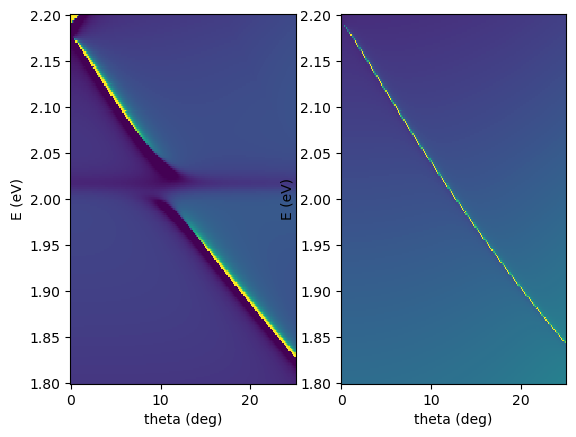

In [39]:
from scipy import ndimage
results  = results_with_grating - results_no_grating
cwl = (stopWavelength+startWavelength)/2
k =  2*n_SiN(cwl)*np.pi*(np.sin(th)/cwl)
# plt.pcolor(thetas/rad_per_deg, hc/wl[:-1], np.diff(results,axis=0))
# plt.pcolor(thetas/rad_per_deg, hc/wl, ndimage.sobel(results,axis=0)+ndimage.sobel(results,axis=0))
plt.subplot(1,2,1)
# plt.pcolor(thetas/rad_per_deg, hc/wl, results>0.006)
# plt.pcolor(thetas/rad_per_deg, hc/wl, ndimage.sobel(results,axis=0))
plt.pcolor(thetas/rad_per_deg, hc/wl, results_with_grating-results_no_grating)
# plt.colorbar()

plt.clim([0.002,0.05])
# plt.ylim([1.96,2.09])
plt.xlabel('theta (deg)')
plt.ylabel('E (eV)')

plt.subplot(1,2,2)
plt.pcolor(thetas/rad_per_deg, hc/wl, results_no_monolayer)
plt.clim([0.002,0.5])
# plt.colorbar()
# plt.clim([0.002,0.5])
# plt.ylim([1.96,2.09])
plt.xlabel('theta (deg)')
plt.ylabel('E (eV)')


# Save Results:

In [40]:
import pickle
with open('python_RWCA_'+str(period)+'.pkl', 'wb') as handle:
    a = {'wavelength': wl, 'E': hc/wl, 'theta': th, 'R_no_monolayer': results_no_monolayer, 'R_with_monolayer': results}
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import skimage.feature
edges = skimage.feature.canny(
    image=ndimage.maximum_filter(results_no_monolayer, size=(20,20)),
    sigma=1,
    low_threshold=0.014,
    high_threshold=0.015,
)
plt.imshow(results_no_monolayer)
plt.clim([0.002,0.02])

plt.imshow(edges, alpha=0.2, cmap='Reds')